In [1]:
%load_ext autoreload
%autoreload 2

import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import random
import sys
from tifffile import imread

# Change this folder to where the cloned `alignment` repository is
sys.path.insert(0, '/Users/minelarinel/alignment')

from alignment import caiman_memmap_reader, minmax_scaler
from registration import sitkalignment

logging.getLogger('matplotlib').setLevel(logging.ERROR)

cv2 not available


#### To align the hindbrain, we will use a plane in the functional images of each recording. So unlike vagal recordings, which are aligned based on a single z-projected anatomy image, we will align hindbrain neurons based on a plane in the volumetric functional imaging data.

In [ ]:
# Folder where the experiment folders are
# CHANGE THIS PATH
data_folder = r'/Volumes/Rapid/Arinel_et_al_2025/Data/Fig3'

# Target data
# CHANGE THIS exp_folder to each individual fish's experiment folder
exp_folder_name = 'elavl3H2BGCaMP8m_8dpf_fed_eggwater_0mM_18_20231206'
exp_folder = Path(data_folder).joinpath(exp_folder_name)

# Reference data for alignment
source_img_path = Path(r'./reference_images/hindbrain/anatomystack-000_Cycle00001_Ch2_000001.ome.tif')

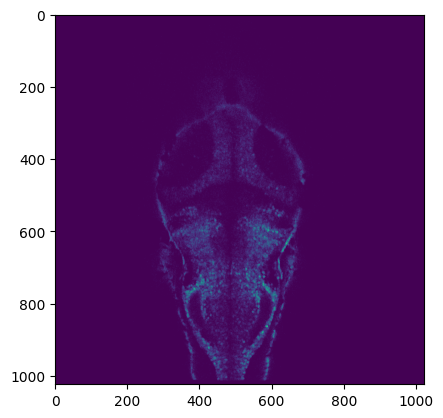

In [5]:
# Load the reference (i.e., source) image
anatomy_plane_of_interest = 9 # need to only choose one plane

source_img_stack = imread(source_img_path)

source_img = source_img_stack[anatomy_plane_of_interest, :, :]
source_img = sitkalignment.embed_image(source_img, 1024) # matching image sizes to 1024x1024

source_img = source_img / source_img.max() # rescaling pixel brightness
source_img *= 2**12

plt.imshow(source_img)

# Find best target plane

Gather all target images that you align to the source image into a list if you want to run z alignment

In [7]:
batch_path = exp_folder.joinpath("mesmerize-batch/batch.pickle")
df = pd.read_pickle(Path(batch_path))
df = df[df['algo'] == "mcorr"]

filenames = list(df.uuid)
target_img_paths = list()

with os.scandir(exp_folder.joinpath("mesmerize-batch")) as entries:
	for entry in entries:
		if entry.name in filenames:
			
			with os.scandir(entry.path) as subentries:
				for subentry in subentries:
					if subentry.name.endswith(".mmap"):
						target_img_paths.append(subentry.path)

target_img_lst = list()
for img_path in target_img_paths:
	img_stack = caiman_memmap_reader(img_path, mode='r')

	target_img = np.nanstd(img_stack, axis=0)

	target_img = target_img / target_img.max()
	target_img *= 2**12

	target_img = sitkalignment.embed_image(target_img, 1024)

	target_img_lst.append(target_img)

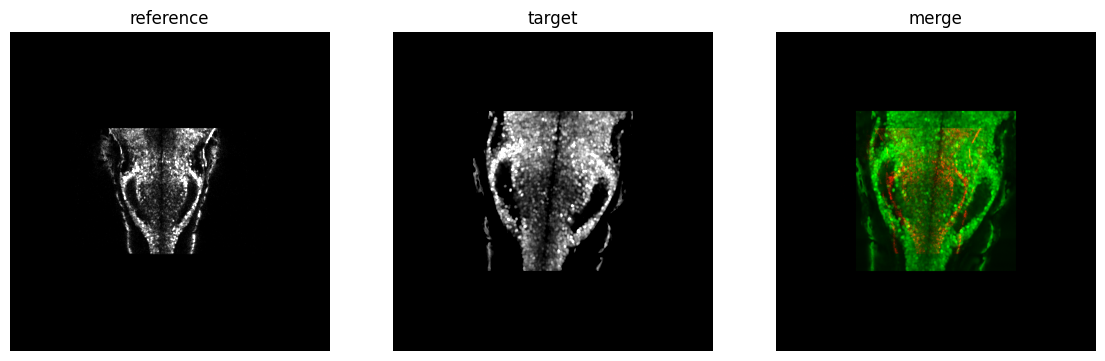

In [8]:
# Visualize unaligned source and target images
# Change the vmin and vmax settings for better visualization and better alignment
# Increasing the contrast of landmarks helps with the alignment
plane = 3
target_vmin = 400
target_vmax = 1700
source_vmax = 1200
plot_img_line_xval = 0  # blocking out top of functional image with 0's
source_img_line_xval = 0  # blocking out top of reference image with 0's

########################################

plot_img = target_img_lst[plane]

fig, ax = plt.subplots(1, 3, figsize=(14, 6))

_plot_img = plot_img.copy()
_plot_img[0:plot_img_line_xval] = 0

_source_img = source_img.copy()
_source_img[0:source_img_line_xval] = 0

ax[0].imshow(
    _source_img,
    cmap="gray",
    vmin=0,
    vmax=source_vmax  # max is 4096
)
ax[1].imshow(
    _plot_img, 
    cmap="gray",
    vmin=target_vmin,
    vmax=target_vmax  # max is 4096
)

[a.axis("off") for a in ax]

merge = np.zeros(
    (_source_img.shape[0], _source_img.shape[1], 3)
)  # assumes same size images
merge[:, :, 0] = 2 * _source_img / _source_img.max()
merge[:, :, 1] = 2 * _plot_img / _plot_img.max()
ax[-1].imshow(merge)

ax[0].set_title("reference")
ax[1].set_title("target")
ax[-1].set_title("merge")
plt.show()

In [258]:
_source_img = minmax_scaler(_source_img, vmin=0, vmax=source_vmax)
_plot_img = minmax_scaler(_plot_img, vmin=target_vmin, vmax=target_vmax)

# Reverse alignment

In [ ]:
%%time
# Saving the reverse alignment in this path (in the same folder as the functional volume)
save_path = exp_folder.joinpath("alignment_rev")

# register_image2 is the correct function to use

# can change scalePenalty and iterations
# increase iterations to get better result
# lower scale penalty if you want more warp

scale_penalties = [150]
iterations = [(10000, 500)]

registered_images = list()
for sp in scale_penalties:
	for it in iterations:
		registered_image = sitkalignment.register_image2(_plot_img, _source_img, save_path, scalePenalty=sp, iterations=it)
		registered_images.append(registered_image)

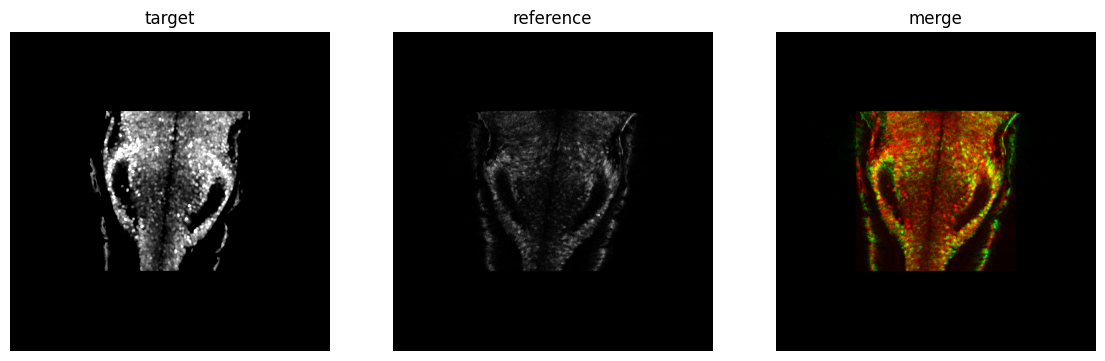

In [262]:
for registered_image in registered_images:
	fig, ax = plt.subplots(1, 3, figsize=(14, 6))

	ax[0].imshow(
		target_img,
		cmap="gray",
		vmin=target_vmin, 
		vmax=target_vmax
	)
	ax[1].imshow(
		registered_image,
		cmap="gray",
		vmin=0, vmax=source_vmax
	)

	[a.axis("off") for a in ax]

	merge = np.zeros(
		(target_img.shape[0], target_img.shape[1], 3)
	)  # assumes same size images
	merge[:, :, 0] = 2 * target_img / target_img.max()
	merge[:, :, 1] = 2 * registered_image / registered_image.max()
	ax[-1].imshow(merge)

	ax[0].set_title("target")
	ax[1].set_title("reference")
	ax[-1].set_title("merge")
	plt.show()

# Find points on functional stack back to reference stack

Checking alignment transformations look good

In [264]:
n_points = 10

mypoints = list()
fish_id = int(exp_folder.name.split('_')[-2])
save_path = exp_folder.joinpath("alignment_rev")

coms = random.sample(list(df[(df.fish_id == fish_id) & (df.plane == plane)]["com"]), n_points)
for x, y in coms:
    mypoints.append((x + 256, y + 256))
    
rev_points = sitkalignment.transform_points(Path(save_path), mypoints)

ELASTIX version: 5.0.1
Command line options from ElastixBase:
-out      /Volumes/Rapid/bruker2P_data/hindbrain/elavl3H2BGCaMP8m_8dpf_fed_glycine_25mM_76_20240814/alignment_rev/
-threads  unspecified, so all available threads are used
-def      /Volumes/Rapid/bruker2P_data/hindbrain/elavl3H2BGCaMP8m_8dpf_fed_glycine_25mM_76_20240814/alignment_rev/point_set.txt
-jac      unspecified, so no det(dT/dx) computed
-jacmat   unspecified, so no dT/dx computed
Calling all ReadFromFile()'s ...
  The default value "false" is used instead.
  The default value "false" is used instead.
  Calling all ReadFromFile()'s took 0.008327 s
Transforming points ...
  The transform is evaluated on some points, specified in the input point file.
  Reading input point file: /Volumes/Rapid/bruker2P_data/hindbrain/elavl3H2BGCaMP8m_8dpf_fed_glycine_25mM_76_20240814/alignment_rev/point_set.txt
  Input points are specified in world coordinates.
  Number of specified input points: 10
  The input points are transformed.

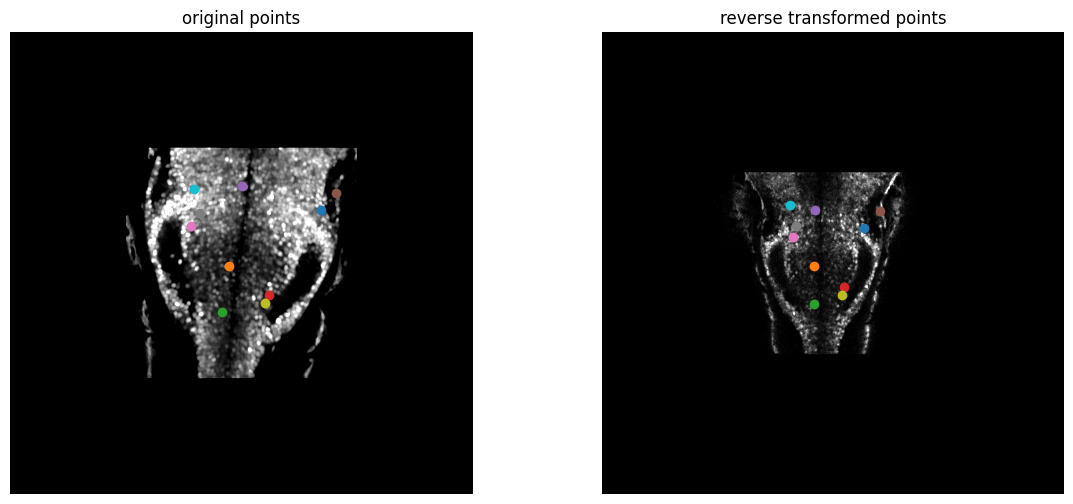

In [265]:
# Plot the original points on the target image vs. transformed points on the reference image
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].imshow(
    target_img_lst[plane],
    cmap="gray",
    vmin=target_vmin,
    vmax=target_vmax 
)
for p in mypoints:
    ax[0].scatter(p[0], p[1])
ax[0].set_title('original points')

ax[1].imshow(
    source_img,
    cmap="gray",
    vmin=0,
    vmax=2000,
)
ax[1].set_title('reverse transformed points')
for p in rev_points:
    ax[1].scatter(p[0], p[1])

[a.axis("off") for a in ax]
plt.show()

## Testing this alignment on multiple planes

In [ ]:
# visualize images
n_points = 10
plane_idxs = [3, 5, 7, 9, 11]

for plane, plot_img in enumerate(target_img_lst):
	mypoints = list()
	fish_id = int(exp_folder.name.split('_')[-2])

	coms = random.sample(list(df[(df.fish_id == fish_id) & (df.plane == plane)]["com"]), n_points)
	for x, y in coms:
		mypoints.append((x + 256, y + 256))
		
	rev_points = sitkalignment.transform_points(Path(save_path), mypoints)

	fig, ax = plt.subplots(1, 2, figsize=(14, 6))

	source_plane = source_img_stack[plane_idxs[plane], :, :]
	source_plane = sitkalignment.embed_image(source_plane, 1024) # matching image sizes to 1024x1024
	source_plane = source_plane / source_plane.max() # rescaling pixel brightness
	source_plane *= 2**12

	ax[0].imshow(
		plot_img,
		cmap="gray",
		vmin=500,
		vmax=3000,
	)
	for p in mypoints:
		ax[0].scatter(p[0],p[1])
	ax[0].set_title('original points')

	ax[1].imshow(
		source_plane,
		cmap="gray",
		vmin=0,
		vmax=2000,
	)
	ax[1].set_title('reverse transformed points')
	for p in rev_points:
		ax[1].scatter(p[0],p[1])

	[a.axis("off") for a in ax]
	plt.show()

In [ ]:
# Update the unrolled_temporal.h5 dataframe with the reverse transformed points
with os.scandir(data_folder) as exp_folders:
	for exp_f in exp_folders:
		if exp_f.name.startswith("elavl3H2BGCaMP8m"):
			exp_folder = exp_f.path
			save_path = os.path.join(exp_folder, "alignment_rev")

			# Load the unrolled_temporal.h5 file to add the reverse transformed points
			df = pd.read_hdf(os.path.join(exp_folder, "unrolled_temporal.h5"))
			df["com_aligned"] = None
			
			for i, row in df.iterrows():
				rev_point = sitkalignment.transform_points(Path(save_path), [(row.com[0] + 256, row.com[1] + 256)])
				df.at[i, "com_aligned"] = (rev_point[0][0], rev_point[0][1])

			df.to_hdf(os.path.join(exp_folder, "unrolled_temporal.h5") , key='unrolled_temporal', mode='w')

## Label the "neurons" on the skin as non-responsive

In [ ]:
# The elavl3:H2B-GCaMP8m line has autofluorescence in the skin.
# Folder where the masks are to remove the "neurons" on the skin
# THE MASKS IN THIS FOLDER NEED TO BE CHANGED TO ACCOUNT FOR THE ENTIRE BRAIN
masks_folder = r'./reference_images/hindbrain/masks that remove the skin'

with os.scandir(data_folder) as exp_folders:
	for exp_f in exp_folders:
		if exp_f.name.startswith("elavl3H2BGCaMP8m"):
			exp_folder = exp_f.path

			# Load the unrolled_temporal.h5 file to add the reverse transformed points
			df = pd.read_hdf(os.path.join(exp_folder, "unrolled_temporal.h5"))

			with os.scandir(masks_folder) as entries:
				for entry in entries:
					if entry.name.endswith('.tif'):
						mask = imread(entry.path)
						mask = sitkalignment.embed_image(mask, 1024)

						plane = int(entry.name.split(' ')[1])

						# since the images are embedded, instead of finding the points to remove, 
						# we'll find the points to keep instead
						keep_points = np.vstack([np.where(mask == 255)[1], np.where(mask == 255)[0]]).transpose()

						for i, row in df[df.plane == plane].iterrows():
							if not np.any(np.logical_and(keep_points[:, 0] == row["com_aligned"][0], keep_points[:, 1] == row["com_aligned"][1])):
								df.loc[i, "responsive"] = False
								df.loc[i, "activated"] = False
								df.loc[i, "suppressed"] = False

			df.to_hdf(os.path.join(exp_folder, "unrolled_temporal.h5"), key='unrolled_temporal', mode='w')

(290.0, 690.0, 710.0, 310.0)

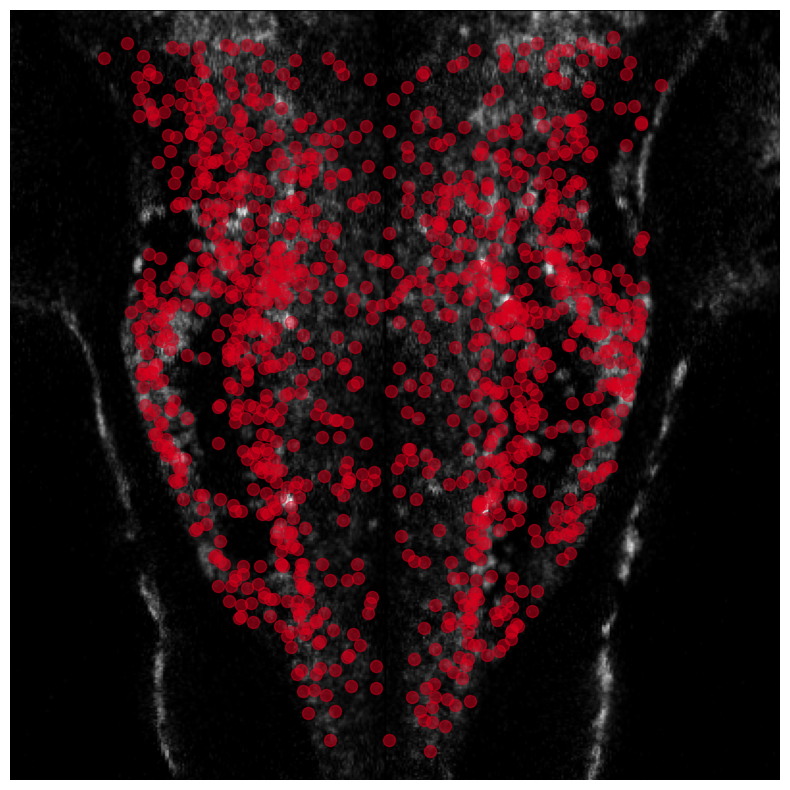

In [ ]:
# Visualize the neurons
plane = 2

plane_idxs = [4, 6, 8, 10, 12]
fig, ax = plt.subplots(figsize=(10, 10))

avg_img = source_img_stack[plane_idxs[plane]]
avg_img = sitkalignment.embed_image(avg_img, 1024)

plt.imshow(avg_img, cmap="gray", vmax=500)

with os.scandir(data_folder) as exp_folders:
	for exp_f in exp_folders:
		if exp_f.name.startswith("elavl3H2BGCaMP8m"):
			exp_folder = exp_f.path

			# Load the unrolled_temporal.h5 file
			df = pd.read_hdf(os.path.join(exp_folder, "unrolled_temporal.h5"))

			for i, com in enumerate(df[(df.responsive == True) & (df.plane == plane)]["com_aligned"]):
				plt.scatter(com[0], com[1], color='#D7001C', alpha=0.5, s=75)

plt.xlim(290, 290+400)
plt.ylim(310+400, 310)
plt.axis('off')